In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.1 MB/s 


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_addons as tfa
import tensorflow_datasets as tfds

import cv2
tfds.disable_progress_bar()
autotune = tf.data.AUTOTUNE

In [ ]:
def controller(img, brightness=255, contrast=127):
    brightness = int((brightness - 0) * (255 - (-255)) / (510 - 0) + (-255))
    contrast = int((contrast - 0) * (127 - (-127)) / (254 - 0) + (-127))
    if brightness != 0:
 
        if brightness > 0:
 
            shadow = brightness
 
            max = 255
 
        else:
 
            shadow = 0
            max = 255 + brightness
 
        al_pha = (max - shadow) / 255
        ga_mma = shadow
 
        # The function addWeighted
        # calculates the weighted sum
        # of two arrays
        cal = cv2.addWeighted(img, al_pha,
                              img, 0, ga_mma)
 
    else:
        cal = img
 
    if contrast != 0:
        Alpha = float(131 * (contrast + 127)) / (127 * (131 - contrast))
        Gamma = 127 * (1 - Alpha)
 
        # The function addWeighted calculates
        # the weighted sum of two arrays
        cal = cv2.addWeighted(cal, Alpha,
                              cal, 0, Gamma)
 
    # putText renders the specified
    # text string in the image.
    
 
    return cal

In [ ]:
!wget http://biomedic.doc.ic.ac.uk/brain-development/downloads/IXI/IXI-T1.tar

--2022-09-07 02:39:16--  http://biomedic.doc.ic.ac.uk/brain-development/downloads/IXI/IXI-T1.tar
Resolving biomedic.doc.ic.ac.uk (biomedic.doc.ic.ac.uk)... 146.169.22.31
Connecting to biomedic.doc.ic.ac.uk (biomedic.doc.ic.ac.uk)|146.169.22.31|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://biomedic.doc.ic.ac.uk/brain-development/downloads/IXI/IXI-T1.tar [following]
--2022-09-07 02:39:16--  https://biomedic.doc.ic.ac.uk/brain-development/downloads/IXI/IXI-T1.tar
Connecting to biomedic.doc.ic.ac.uk (biomedic.doc.ic.ac.uk)|146.169.22.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4840816640 (4.5G) [application/x-tar]
Saving to: ‘IXI-T1.tar’

IXI-T1.tar          100%[===================>]   4.51G  32.3MB/s    in 2m 23s  

2022-09-07 02:41:40 (32.3 MB/s) - ‘IXI-T1.tar’ saved [4840816640/4840816640]



In [ ]:
# !gdown  17wOmd0IrQk8-0bnPxyLxkCNqtmtBjEYG

In [ ]:
# !unzip /content/weights.zip

In [ ]:
import tarfile
  
# open file
file = tarfile.open('/content/IXI-T1.tar')
  
# extracting file
file.extractall('./Destination_FolderName')
  
file.close()

In [ ]:
import glob
len(glob.glob('/content/Destination_FolderName/*-HH-*.nii.gz')),len(glob.glob('/content/Destination_FolderName/*-Guys-*.nii.gz')),len(glob.glob('/content/Destination_FolderName/*-IOP-*.nii.gz'))

(185, 322, 74)

In [ ]:
import nibabel as nib
img_3T = nib.load('/content/Destination_FolderName/IXI218-HH-1815-T1.nii.gz')
img_1T = nib.load('/content/Destination_FolderName/IXI219-Guys-0894-T1.nii.gz')

img_3T = img_3T.get_fdata()
img_1T = img_1T.get_fdata()

img_1T.shape,img_3T.shape

((256, 256, 150), (256, 256, 150))

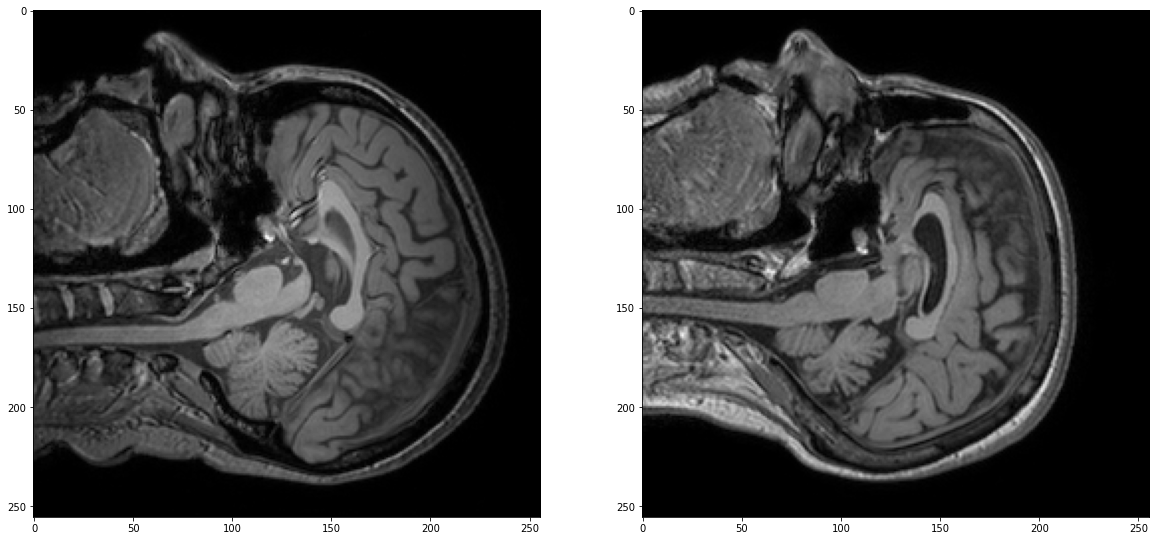

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(img_3T[...,img_3T.shape[2]//2],cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img_1T[...,img_1T.shape[2]//2],cmap='gray')

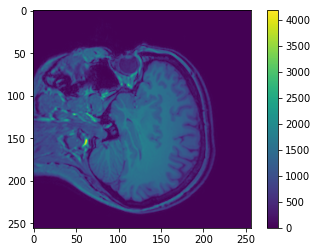

In [ ]:
def load_image(path):
  img = nib.load(path)
  return img.get_fdata()
plt.imshow(load_image('/content/Destination_FolderName/IXI014-HH-1236-T1.nii.gz')[:,:,100])
plt.colorbar()

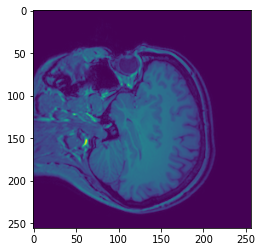

In [ ]:
plt.imshow(load_image('/content/Destination_FolderName/IXI014-HH-1236-T1.nii.gz')[:,:,100])

In [ ]:
list_3T = glob.glob('/content/Destination_FolderName/*-HH-*.nii.gz')
list_1T = glob.glob('/content/Destination_FolderName/*-Guys-*.nii.gz')[:111] + glob.glob('/content/Destination_FolderName/*-IOP-*.nii.gz')

len(list_1T),len(list_3T)

(185, 185)

In [ ]:
list_1T = np.array(list_1T)
list_3T = np.array(list_3T)

In [ ]:
np.random.seed(0)
list_1T = list_1T[np.random.permutation(185)]
list_3T = list_3T[np.random.permutation(185)]

In [ ]:
list_3T_train = list_3T[:148].copy()
list_3T_test = list_3T[148:]

list_1T_train = list_1T[:148].copy()
list_1T_test = list_1T[148:]

In [ ]:
def load_data_1T_train():
  n=0
  for mri in list_1T_train:
    img = load_image(mri)
    img_shape = img.shape[2]
    start = (img_shape-100)//2
    np.random.seed(n)
    img = img[:,:,start:start+100]
    img = img[:,:,np.random.permutation(100)]
    n += 1
    for i in range(100):
      img_255 = img[:,:,i]
      img_255 /= (np.max(img_255)/255.)
      yield np.stack([img_255,img_255,img_255] ,axis=-1)

def load_data_3T_train():
  n=0
  for mri in list_3T_train:
    img = load_image(mri)
    img_shape = img.shape[2]
    start = (img_shape-100)//2
    np.random.seed(n)
    img = img[:,:,start:start+100]
    img = img[:,:,np.random.permutation(100)]
    n += 1
    for i in range(100):
      img_255 = img[:,:,i]
      img_255 /= (np.max(img_255)/255.)
      yield np.stack([img_255,img_255,img_255] ,axis=-1)

def load_data_1T_test():
  n=0
  for mri in list_1T_test:
    img = load_image(mri)
    img_shape = img.shape[2]
    start = (img_shape-100)//2
    np.random.seed(n)
    img = img[:,:,start:start+100]
    # img = img[:,:,np.random.permutation(100)]
    n += 1
    for i in range(100):
      img_255 = img[:,:,i]
      img_255 /= (np.max(img_255)/255.)
      yield np.stack([img_255,img_255,img_255] ,axis=-1)

def load_data_3T_test():
  n=0
  for mri in list_3T_test:
    img = load_image(mri)
    img_shape = img.shape[2]
    start = (img_shape-100)//2
    np.random.seed(n)
    img = img[:,:,start:start+100]
    # img = img[:,:,np.random.permutation(100)]
    n += 1
    for i in range(100):
      img_255 = img[:,:,i]
      img_255 /= (np.max(img_255)/255.)
      yield np.stack([img_255,img_255,img_255] ,axis=-1)

In [ ]:
train_low = tf.data.Dataset.from_generator(
     load_data_1T_train,
     (tf.float32),
    (tf.TensorShape([256,256,3])))
train_high = tf.data.Dataset.from_generator(
     load_data_3T_train,
     (tf.float32),
    (tf.TensorShape([256,256,3])))
test_low = tf.data.Dataset.from_generator(
     load_data_1T_test,
     (tf.float32),
    (tf.TensorShape([256,256,3])))
test_high = tf.data.Dataset.from_generator(
     load_data_3T_test,
     (tf.float32),
    (tf.TensorShape([256,256,3])))

In [ ]:
# train_horses = tf.data.Dataset.from_generator(
#      load_train_low,
#      (tf.float32),
#     (tf.TensorShape([256,256,3])))
# train_zebras = tf.data.Dataset.from_generator(
#      load_train_high,
#      (tf.float32),
#     (tf.TensorShape([256,256,3])))
# test_horses = tf.data.Dataset.from_generator(
#      load_train_low,
#      (tf.float32),
#     (tf.TensorShape([256,256,3])))
# test_zebras = tf.data.Dataset.from_generator(
#      load_train_high,
#      (tf.float32),
#     (tf.TensorShape([256,256,3])))

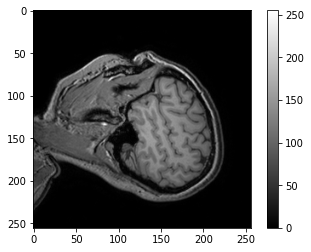

In [ ]:
for i in test_high.take(10):
  sample_img = np.array(i).copy()
plt.imshow(sample_img[:,:,0],cmap='gray')
plt.colorbar()

## Prepare the dataset

In this example, we will be using the
[horse to zebra](https://www.tensorflow.org/datasets/catalog/cycle_gan#cycle_ganhorse2zebra)
dataset.

In [ ]:
# Load the horse-zebra dataset using tensorflow-datasets.
# dataset, _ = tfds.load("cycle_gan/horse2zebra", with_info=True, as_supervised=True)
# train_horses, train_zebras = dataset["trainA"], dataset["trainB"]
# test_horses, test_zebras = dataset["testA"], dataset["testB"]

# Define the standard image size.
orig_img_size = (256, 256)
# Size of the random crops to be used during training.
input_img_size = (256, 256, 3)
input_img_size_patch = (32, 32, 3)
# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
buffer_size = 256
batch_size = 1

def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    return (img / 127.5) - 1.0

def preprocess_train_image(img):
    img = tf.image.resize(img, [*orig_img_size])
    # img = tf.image.random_crop(img, size=[*input_img_size])
    img = normalize_img(img)
    return img

def preprocess_test_image(img):
    img = tf.image.resize(img, [input_img_size[0], input_img_size[1]])
    #img = tf.image.random_crop(img, size=[*input_img_size])
    img = normalize_img(img)
    return img

## Create `Dataset` objects

In [ ]:
train_low = (
    train_low.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
train_high = (
    train_high.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)

test_low = (
    test_low.map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
test_high = (
    test_high.map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)

## Visualize some samples

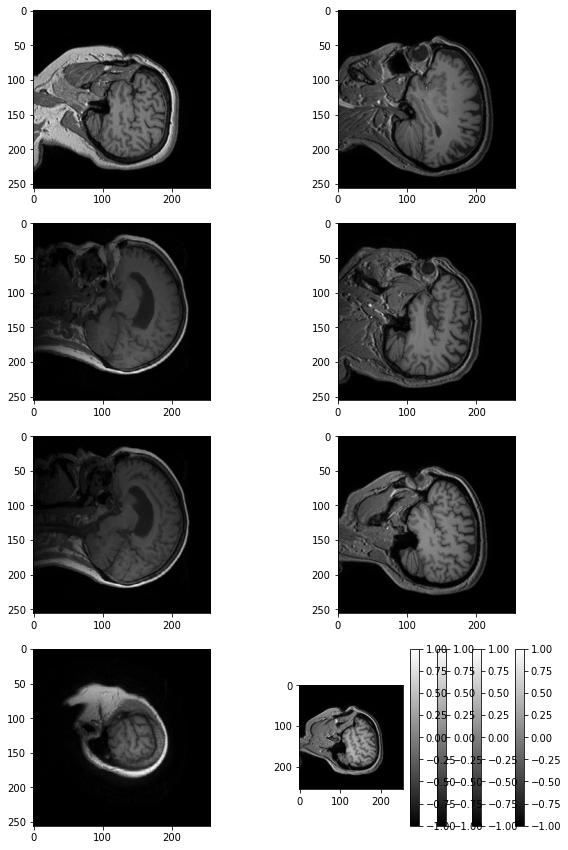

In [ ]:
_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, samples in enumerate(zip(train_low.skip(5).take(4), train_high.skip(5).take(4))):
    t1t = (((samples[0][0])).numpy())
    t3t = (((samples[1][0])).numpy())
    ax[i, 0].imshow((t1t[:,:,0]),cmap="gray")
    fig = ax[i, 1].imshow(t3t[:,:,2],cmap="gray")
    plt.colorbar(fig)
plt.show()

## Building blocks used in the CycleGAN generators and discriminators

In [ ]:
class ReflectionPadding2D(layers.Layer):
    """Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x


def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


In [ ]:
def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(
        x
    )
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model

## Build the discriminators

The discriminators implement the following architecture:
`C64->C128->C256->C512`

In [ ]:
def get_discriminator(
    filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer
    )(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model

def get_patch_discriminator(
    filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None):
    img_input = layers.Input(shape=input_img_size_patch, name=name + "_img_input")
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer
    )(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model


# Get the generators
gen_G = get_resnet_generator(name="generator_G")
gen_F = get_resnet_generator(name="generator_F")

# Get the discriminators
disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(name="discriminator_Y")

patch_disc_X = get_patch_discriminator(name="patch_discriminator_X")
patch_disc_Y = get_patch_discriminator(name="patch_discriminator_Y")

In [ ]:
gen_G.summary()

Model: "generator_G"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 generator_G_img_input (InputLa  [(None, 256, 256, 3  0          []                               
 yer)                           )]                                                                
                                                                                                  
 reflection_padding2d_40 (Refle  (None, 262, 262, 3)  0          ['generator_G_img_input[0][0]']  
 ctionPadding2D)                                                                                  
                                                                                                  
 conv2d_64 (Conv2D)             (None, 256, 256, 64  9408        ['reflection_padding2d_40[0][0]']
                                )                                                       

In [ ]:
gen_G.summary()

Model: "generator_G"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 generator_G_img_input (InputLa  [(None, 256, 256, 3  0          []                               
 yer)                           )]                                                                
                                                                                                  
 reflection_padding2d_40 (Refle  (None, 262, 262, 3)  0          ['generator_G_img_input[0][0]']  
 ctionPadding2D)                                                                                  
                                                                                                  
 conv2d_64 (Conv2D)             (None, 256, 256, 64  9408        ['reflection_padding2d_40[0][0]']
                                )                                                       

In [ ]:
disc_X.summary()

Model: "discriminator_X"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 discriminator_X_img_input (  [(None, 256, 256, 3)]    0         
 InputLayer)                                                     
                                                                 
 conv2d_108 (Conv2D)         (None, 128, 128, 64)      3136      
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 128, 128, 64)      0         
                                                                 
 conv2d_109 (Conv2D)         (None, 64, 64, 128)       131072    
                                                                 
 instance_normalization_104   (None, 64, 64, 128)      256       
 (InstanceNormalization)                                         
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 64, 64, 128)   

## Build the CycleGAN model

We will override the `train_step()` method of the `Model` class
for training via `fit()`.

In [ ]:
class CycleGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        patch_discriminator_X,
        patch_discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super(CycleGan, self).__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.patch_disc_X = patch_discriminator_X
        self.patch_disc_Y = patch_discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def call(self, inputs):
        return (
            self.disc_X(inputs),
            self.disc_Y(inputs),
            self.patch_disc_X(inputs),
            self.patch_disc_Y(inputs),
            self.gen_G(inputs),
            self.gen_F(inputs),
        )

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        patch_disc_X_optimizer,
        patch_disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        disc_acc_fn,
        gen_psnr,
    ):
        super(CycleGan, self).compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.patch_disc_X_optimizer = patch_disc_X_optimizer
        self.patch_disc_Y_optimizer = patch_disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.generator_psnr = gen_psnr
        self.discriminator_loss_fn = disc_loss_fn
        self.discriminator_acc_fn = disc_acc_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        # x is Horse and y is zebra
        real_x, real_y = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # Horse to fake zebra
            fake_y = self.gen_G(real_x, training=True)
            # Zebra to fake horse -> y2x
            fake_x = self.gen_F(real_y, training=True)

            # Cycle (Horse to fake zebra to fake horse): x -> y -> x
            cycled_x = self.gen_F(fake_y, training=True)
            # Cycle (Zebra to fake horse to fake zebra) y -> x -> y
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # patch Discriminator output
            patch_real_x = real_x[:,132:164,132:164]
            patch_real_y = real_y[:,132:164,132:164]

            patch_fake_x = fake_x[:,132:164,132:164]
            patch_fake_y = fake_y[:,132:164,132:164]

            patch_disc_real_x = self.patch_disc_X(patch_real_x, training=True)
            patch_disc_fake_x = self.patch_disc_X(patch_fake_x, training=True)

            patch_disc_real_y = self.patch_disc_Y(patch_real_y, training=True)
            patch_disc_fake_y = self.patch_disc_Y(patch_fake_y, training=True)

            # Generator adverserial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

            # patch_Discriminator loss
            patch_disc_X_loss = self.discriminator_loss_fn(patch_disc_real_x, patch_disc_fake_x)
            patch_disc_Y_loss = self.discriminator_loss_fn(patch_disc_real_y, patch_disc_fake_y)

            disc_X_acc = self.discriminator_acc_fn(disc_real_x, disc_fake_x)
            disc_Y_acc = self.discriminator_acc_fn(disc_real_y, disc_fake_y)

            patch_disc_X_acc = self.discriminator_acc_fn(patch_disc_real_x, patch_disc_fake_x)
            patch_disc_Y_acc = self.discriminator_acc_fn(patch_disc_real_y, patch_disc_fake_y)

            psnr_F = self.generator_psnr(real_x, cycled_x, max_val=2.)
            psnr_G = self.generator_psnr(real_y, cycled_y, max_val=2.)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        patch_disc_X_grads = tape.gradient(patch_disc_X_loss, self.patch_disc_X.trainable_variables)
        patch_disc_Y_grads = tape.gradient(patch_disc_Y_loss, self.patch_disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        # Update the weights of the discriminators
        self.patch_disc_X_optimizer.apply_gradients(
            zip(patch_disc_X_grads, self.patch_disc_X.trainable_variables)
        )
        self.patch_disc_Y_optimizer.apply_gradients(
            zip(patch_disc_Y_grads, self.patch_disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,

            "G_psnr": psnr_G,
            "F_psnr": psnr_F,

            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,

            "D_X_acc": disc_X_acc,
            "D_Y_acc": disc_Y_acc,

            "patch_D_X_acc": patch_disc_X_acc,
            "patch_D_Y_acc": patch_disc_Y_acc,
        }

## Create a callback that periodically saves generated images

In [ ]:
# class GANMonitor(keras.callbacks.Callback):
#     """A callback to generate and save images after each epoch"""

#     def __init__(self, num_img=4):
#         self.num_img = num_img

#     def on_epoch_end(self, epoch, logs=None):
#         _, ax = plt.subplots(4, 2, figsize=(12, 12))
#         for i, img in enumerate(test_horses.take(self.num_img)):
#             prediction = self.model.gen_G(img)[0].numpy()
#             prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
#             img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

#             ax[i, 0].imshow(img)
#             ax[i, 1].imshow(prediction)
#             ax[i, 0].set_title("Input image")
#             ax[i, 1].set_title("Translated image")
#             ax[i, 0].axis("off")
#             ax[i, 1].axis("off")

#             prediction = keras.preprocessing.image.array_to_img(prediction)
#             prediction.save(
#                 "generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch + 1)
#             )
#         plt.show()
#         plt.close()

class GANMonitor(keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=16):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        os.system(f'mkdir /content/model_checkpoints/1Tto3T_epoch_{epoch+1}')
        for i, img in enumerate(test_low.take(self.num_img)):
            prediction = self.model.gen_G(img)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
            merge = np.concatenate((img,prediction),axis=1)
            
            cv2.imwrite(f'/content/model_checkpoints/1Tto3T_epoch_{epoch+1}/{i}.png',merge)

        os.system(f'mkdir /content/model_checkpoints/3Tto1T_epoch_{epoch+1}')
        for i, img in enumerate(test_high.take(self.num_img)):
            prediction = self.model.gen_F(img)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
            merge = np.concatenate((img,prediction),axis=1)
            
            cv2.imwrite(f'/content/model_checkpoints/3Tto1T_epoch_{epoch+1}/{i}.png',merge)

In [ ]:
!rm -r /content/model_checkpoints

In [ ]:
psnr = tf.image.psnr
# psnr = psnr(im1, im2, max_val=255.)

## Train the end-to-end model

In [ ]:
# Loss function for evaluating adversarial loss
adv_loss_fn = keras.losses.MeanSquaredError()
adv_acc_fn = keras.metrics.Accuracy()


# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss


# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5

def discriminator_acc_fn(real, fake):
    real_acc = adv_acc_fn(tf.ones_like(real), real>0.5)
    fake_acc = adv_acc_fn(tf.zeros_like(fake), fake>0.5)
    return (real_acc + fake_acc) * 0.5


# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y,patch_discriminator_X=patch_disc_X, patch_discriminator_Y=patch_disc_Y
)

# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    patch_disc_X_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    patch_disc_Y_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
    disc_acc_fn=discriminator_acc_fn,
    gen_psnr  = psnr
)
# Callbacks
plotter = GANMonitor()

In [ ]:
checkpoint_filepath = "/content/model_checkpoints/cyclegan_checkpoints.{epoch:03d}"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint( save_weights_only=True,
    filepath=checkpoint_filepath
)

In [ ]:
history = cycle_gan_model.fit(
    tf.data.Dataset.zip((train_low, train_high)).take(10),
    # validation_data=tf.data.Dataset.zip((test_low, test_high)).take(100),
    epochs=3,
    callbacks=[plotter,model_checkpoint_callback]
)

In [ ]:
np.random.seed(0)
selcet_random_test = (np.random.uniform(0,1,3700)>0.99)
selcet_random_test.sum()

34

In [ ]:
def sub_generator(sub_epoch):
  list_3T_train = list_3T[sub_epoch*37:(sub_epoch+1)*37].copy()
  list_1T_train = list_1T[sub_epoch*37:(sub_epoch+1)*37].copy()
  list_3T_test = list_3T[148:].copy()
  list_1T_test = list_1T[148:].copy()

  def load_data_1T_train():
    n=0
    for mri in list_1T_train:
      img = load_image(mri)
      img_shape = img.shape[2]
      start = (img_shape-100)//2
      np.random.seed(n)
      img = img[:,:,start:start+100]
      img = img[:,:,np.random.permutation(100)]
      n += 1
      for i in range(100):
        img_255 = img[:,:,i]
        img_255 /= (np.max(img_255)/255.)
        yield np.stack([img_255,img_255,img_255] ,axis=-1)

  def load_data_3T_train():
    n=0
    for mri in list_3T_train:
      img = load_image(mri)
      img_shape = img.shape[2]
      start = (img_shape-100)//2
      np.random.seed(n)
      img = img[:,:,start:start+100]
      img = img[:,:,np.random.permutation(100)]
      n += 1
      for i in range(100):
        img_255 = img[:,:,i]
        img_255 /= (np.max(img_255)/255.)
        yield np.stack([img_255,img_255,img_255] ,axis=-1)

  def load_data_1T_test():
    n=0
    for mri in list_1T_test:
      img = load_image(mri)
      img_shape = img.shape[2]
      start = (img_shape-100)//2
      np.random.seed(n)
      img = img[:,:,start:start+100]
      # img = img[:,:,np.random.permutation(100)]
      n += 1
      for i in range(100):
        img_255 = img[:,:,i]
        img_255 /= (np.max(img_255)/255.)
        yield np.stack([img_255,img_255,img_255] ,axis=-1)

  def load_data_3T_test():
    n=0
    for mri in list_3T_test:
      img = load_image(mri)
      img_shape = img.shape[2]
      start = (img_shape-100)//2
      np.random.seed(n)
      img = img[:,:,start:start+100]
      # img = img[:,:,np.random.permutation(100)]
      n += 1
      for i in range(100):
        img_255 = img[:,:,i]
        img_255 /= (np.max(img_255)/255.)
        yield np.stack([img_255,img_255,img_255] ,axis=-1)


  train_low = tf.data.Dataset.from_generator(
      load_data_1T_train,
      (tf.float32),
      (tf.TensorShape([256,256,3])))
  train_high = tf.data.Dataset.from_generator(
      load_data_3T_train,
      (tf.float32),
      (tf.TensorShape([256,256,3])))
  test_low = tf.data.Dataset.from_generator(
      load_data_1T_test,
      (tf.float32),
      (tf.TensorShape([256,256,3])))
  test_high = tf.data.Dataset.from_generator(
      load_data_3T_test,
      (tf.float32),
      (tf.TensorShape([256,256,3])))

  train_low = (
      train_low.map(preprocess_train_image, num_parallel_calls=autotune)
      .cache()
      .shuffle(buffer_size)
      .batch(batch_size)
  )
  train_high = (
      train_high.map(preprocess_train_image, num_parallel_calls=autotune)
      .cache()
      .shuffle(buffer_size)
      .batch(batch_size)
  )

  test_low = (
      test_low.map(preprocess_test_image, num_parallel_calls=autotune)
      .cache()
      .shuffle(buffer_size)
      .batch(batch_size)
  )
  test_high = (
      test_high.map(preprocess_test_image, num_parallel_calls=autotune)
      .cache()
      .shuffle(buffer_size)
      .batch(batch_size)
  )

  return train_low,train_high,test_low,test_high

In [ ]:
best_psnr = 0
os.system(f'mkdir /content/model_checkpoints')
# i_epoch = 1
# sub_epoch = 1
for i_epoch in range(6):
  for sub_epoch in range(4):

    train_low,train_high,test_low,test_high = sub_generator(sub_epoch)
    history = cycle_gan_model.fit(
    tf.data.Dataset.zip((train_low, train_high)).take(3700),
    epochs=1)


    all_real_x = []
    all_fake_y = []

    all_real_y = []
    all_fake_x = []

    os.system(f'mkdir /content/model_checkpoints/1Tto3T_epoch_{i_epoch+1}_{sub_epoch}')
    psnr_val_1Tto3T = []
    for i, img in enumerate(test_low.take(3700)):
        prediction = cycle_gan_model.gen_G(img)[0]

        psnr_val_1Tto3T.append(tf.image.psnr(img,prediction,2).numpy()[0])
        all_real_x.append(cycle_gan_model.disc_X(img))
        all_fake_y.append(cycle_gan_model.disc_Y(np.expand_dims(prediction,0)))
        if selcet_random_test[i]:
          prediction = prediction.numpy()
          prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
          img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
          merge = np.concatenate((img,prediction),axis=1)
          
          cv2.imwrite(f'/content/model_checkpoints/1Tto3T_epoch_{i_epoch+1}_{sub_epoch}/{i}.png',merge)
    psnr_val_1Tto3T = np.mean(psnr_val_1Tto3T)

    psnr_val_3Tto1T = []
    os.system(f'mkdir /content/model_checkpoints/3Tto1T_epoch_{i_epoch+1}_{sub_epoch}')
    for i, img in enumerate(test_high.take(3700)):
        prediction = cycle_gan_model.gen_F(img)[0]
        psnr_val_3Tto1T.append(tf.image.psnr(img,prediction,2).numpy()[0])
        all_real_y.append(cycle_gan_model.disc_Y(img))
        all_fake_x.append(cycle_gan_model.disc_X(np.expand_dims(prediction,0)))
        if selcet_random_test[i]:
          prediction = prediction.numpy()
          prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
          img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
          merge = np.concatenate((img,prediction),axis=1)
          
          cv2.imwrite(f'/content/model_checkpoints/3Tto1T_epoch_{i_epoch+1}_{sub_epoch}/{i}.png',merge)
    psnr_val_3Tto1T = np.mean(psnr_val_3Tto1T)
    disc_val_1T = ((np.array(all_real_x)>0.5).sum()/np.array(all_real_x).flatten().__len__() + 
    (np.array(all_fake_x)<0.5).sum()/np.array(all_fake_x).flatten().__len__())/2
    disc_val_3T = ((np.array(all_real_y)>0.5).sum()/np.array(all_real_y).flatten().__len__() + 
    (np.array(all_fake_y)<0.5).sum()/np.array(all_fake_y).flatten().__len__())/2

    print(f'{i_epoch}_{sub_epoch} - Validation: psnr 1to3:{np.round(psnr_val_1Tto3T,2)} - 3to1:{np.round(psnr_val_3Tto1T,2)}  ---  disc_acc:  1T:{np.round(disc_val_1T,3)} - 3T:{np.round(disc_val_3T,3)}')

    new_psnr = (psnr_val_3Tto1T + psnr_val_1Tto3T)/2
    if new_psnr>best_psnr:
      cycle_gan_model.save_weights('/content/model_checkpoints/cyclegan_checkpoints.best')
      best_psnr = new_psnr

In [ ]:
best_psnr = 0
os.system(f'mkdir /content/model_checkpoints')
# i_epoch = 1
# sub_epoch = 1
for i_epoch in range(6):
  for sub_epoch in range(4):

    train_low,train_high,test_low,test_high = sub_generator(sub_epoch)
    history = cycle_gan_model.fit(
    tf.data.Dataset.zip((train_low, train_high)).take(3700),
    epochs=1)


    all_real_x = []
    all_fake_y = []

    all_real_y = []
    all_fake_x = []

    os.system(f'mkdir /content/model_checkpoints/1Tto3T_epoch_{i_epoch+1}_{sub_epoch}')
    psnr_val_1Tto3T = []
    for i, img in enumerate(test_low.take(3700)):
        prediction = cycle_gan_model.gen_G(img)[0]

        psnr_val_1Tto3T.append(tf.image.psnr(img,prediction,2).numpy()[0])
        all_real_x.append(cycle_gan_model.disc_X(img))
        all_fake_y.append(cycle_gan_model.disc_Y(np.expand_dims(prediction,0)))
        if selcet_random_test[i]:
          prediction = prediction.numpy()
          prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
          img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
          merge = np.concatenate((img,prediction),axis=1)
          
          cv2.imwrite(f'/content/model_checkpoints/1Tto3T_epoch_{i_epoch+1}_{sub_epoch}/{i}.png',merge)
    psnr_val_1Tto3T = np.mean(psnr_val_1Tto3T)

    psnr_val_3Tto1T = []
    os.system(f'mkdir /content/model_checkpoints/3Tto1T_epoch_{i_epoch+1}_{sub_epoch}')
    for i, img in enumerate(test_high.take(3700)):
        prediction = cycle_gan_model.gen_F(img)[0]
        psnr_val_3Tto1T.append(tf.image.psnr(img,prediction,2).numpy()[0])
        all_real_y.append(cycle_gan_model.disc_Y(img))
        all_fake_x.append(cycle_gan_model.disc_X(np.expand_dims(prediction,0)))
        if selcet_random_test[i]:
          prediction = prediction.numpy()
          prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
          img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
          merge = np.concatenate((img,prediction),axis=1)
          
          cv2.imwrite(f'/content/model_checkpoints/3Tto1T_epoch_{i_epoch+1}_{sub_epoch}/{i}.png',merge)
    psnr_val_3Tto1T = np.mean(psnr_val_3Tto1T)
    disc_val_1T = ((np.array(all_real_x)>0.5).sum()/np.array(all_real_x).flatten().__len__() + 
    (np.array(all_fake_x)<0.5).sum()/np.array(all_fake_x).flatten().__len__())/2
    disc_val_3T = ((np.array(all_real_y)>0.5).sum()/np.array(all_real_y).flatten().__len__() + 
    (np.array(all_fake_y)<0.5).sum()/np.array(all_fake_y).flatten().__len__())/2

    print(f'{i_epoch}_{sub_epoch} - Validation: psnr 1to3:{np.round(psnr_val_1Tto3T,2)} - 3to1:{np.round(psnr_val_3Tto1T,2)}  ---  disc_acc:  1T:{np.round(disc_val_1T,3)} - 3T:{np.round(disc_val_3T,3)}')

    new_psnr = (psnr_val_3Tto1T + psnr_val_1Tto3T)/2
    if new_psnr>best_psnr:
      cycle_gan_model.save_weights('/content/model_checkpoints/cyclegan_checkpoints.best')
      best_psnr = new_psnr

In [ ]:
keys = history.history.keys()
values = history.history

for key in keys:
    print(values[key])

[1.983961582183838, 1.8583554029464722, 1.680550217628479, 1.247820258140564, 1.3970873355865479, 2.7154688835144043, 1.621410846710205, 1.8644654750823975, 1.2054402828216553, 1.802939534187317]
[1.9114115238189697, 1.2103893756866455, 1.8620915412902832, 2.035571575164795, 1.3686153888702393, 1.4462240934371948, 1.7396719455718994, 1.3863399028778076, 1.1500986814498901, 1.2605055570602417]
[array([23.009937], dtype=float32), array([24.745432], dtype=float32), array([21.506258], dtype=float32), array([23.990646], dtype=float32), array([24.468462], dtype=float32), array([18.351927], dtype=float32), array([22.012945], dtype=float32), array([21.180836], dtype=float32), array([24.18539], dtype=float32), array([21.51302], dtype=float32)]
[array([21.460367], dtype=float32), array([25.060656], dtype=float32), array([22.49729], dtype=float32), array([22.05838], dtype=float32), array([22.51111], dtype=float32), array([24.293938], dtype=float32), array([19.388971], dtype=float32), array([23.31

In [ ]:

# Load the checkpoints
weight_file = "/content/model_checkpoints/cyclegan_checkpoints.001"
cycle_gan_model.load_weights(weight_file).expect_partial()
print("Weights loaded successfully")

_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, img in enumerate(test_horses.skip(150).take(4)):
    prediction = cycle_gan_model.gen_G(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0]).numpy()

    ax[i, 0].imshow(img[:,:,0],cmap='gray')
    ax[i, 1].imshow(controller(prediction[:,:,:],brightness = 120,contrast = 140),cmap='gray')
    ax[i, 0].set_title("Input image")
    ax[i, 0].set_title("Input image")
    ax[i, 1].set_title("Translated image")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")

    sr = keras.preprocessing.image.array_to_img(prediction)
    original = keras.preprocessing.image.array_to_img(img)
    sr.save("/content/outputs/predicted_img_{i}.png".format(i=i))
    original.save("/content/outputs/original_img_{i}.png".format(i=i))
plt.tight_layout()
plt.show()